# Chapter 7 Moving Beyond Linearity
Linearity is almost always an approximation, need more flexible models.

## Polynomial Regression
+ Extend linear model with polynomial terms (e.g. $X^2, X^3, \ldots$). 
+ It's still a linear (in parameter) model but can model non-linear data. 
+ Usually **don't use polynomial terms higher than degree 3 or 4**

$$
y=\beta_0+\beta_1x_i+\beta_2x^2_i
$$

The model is still linear but in parameters

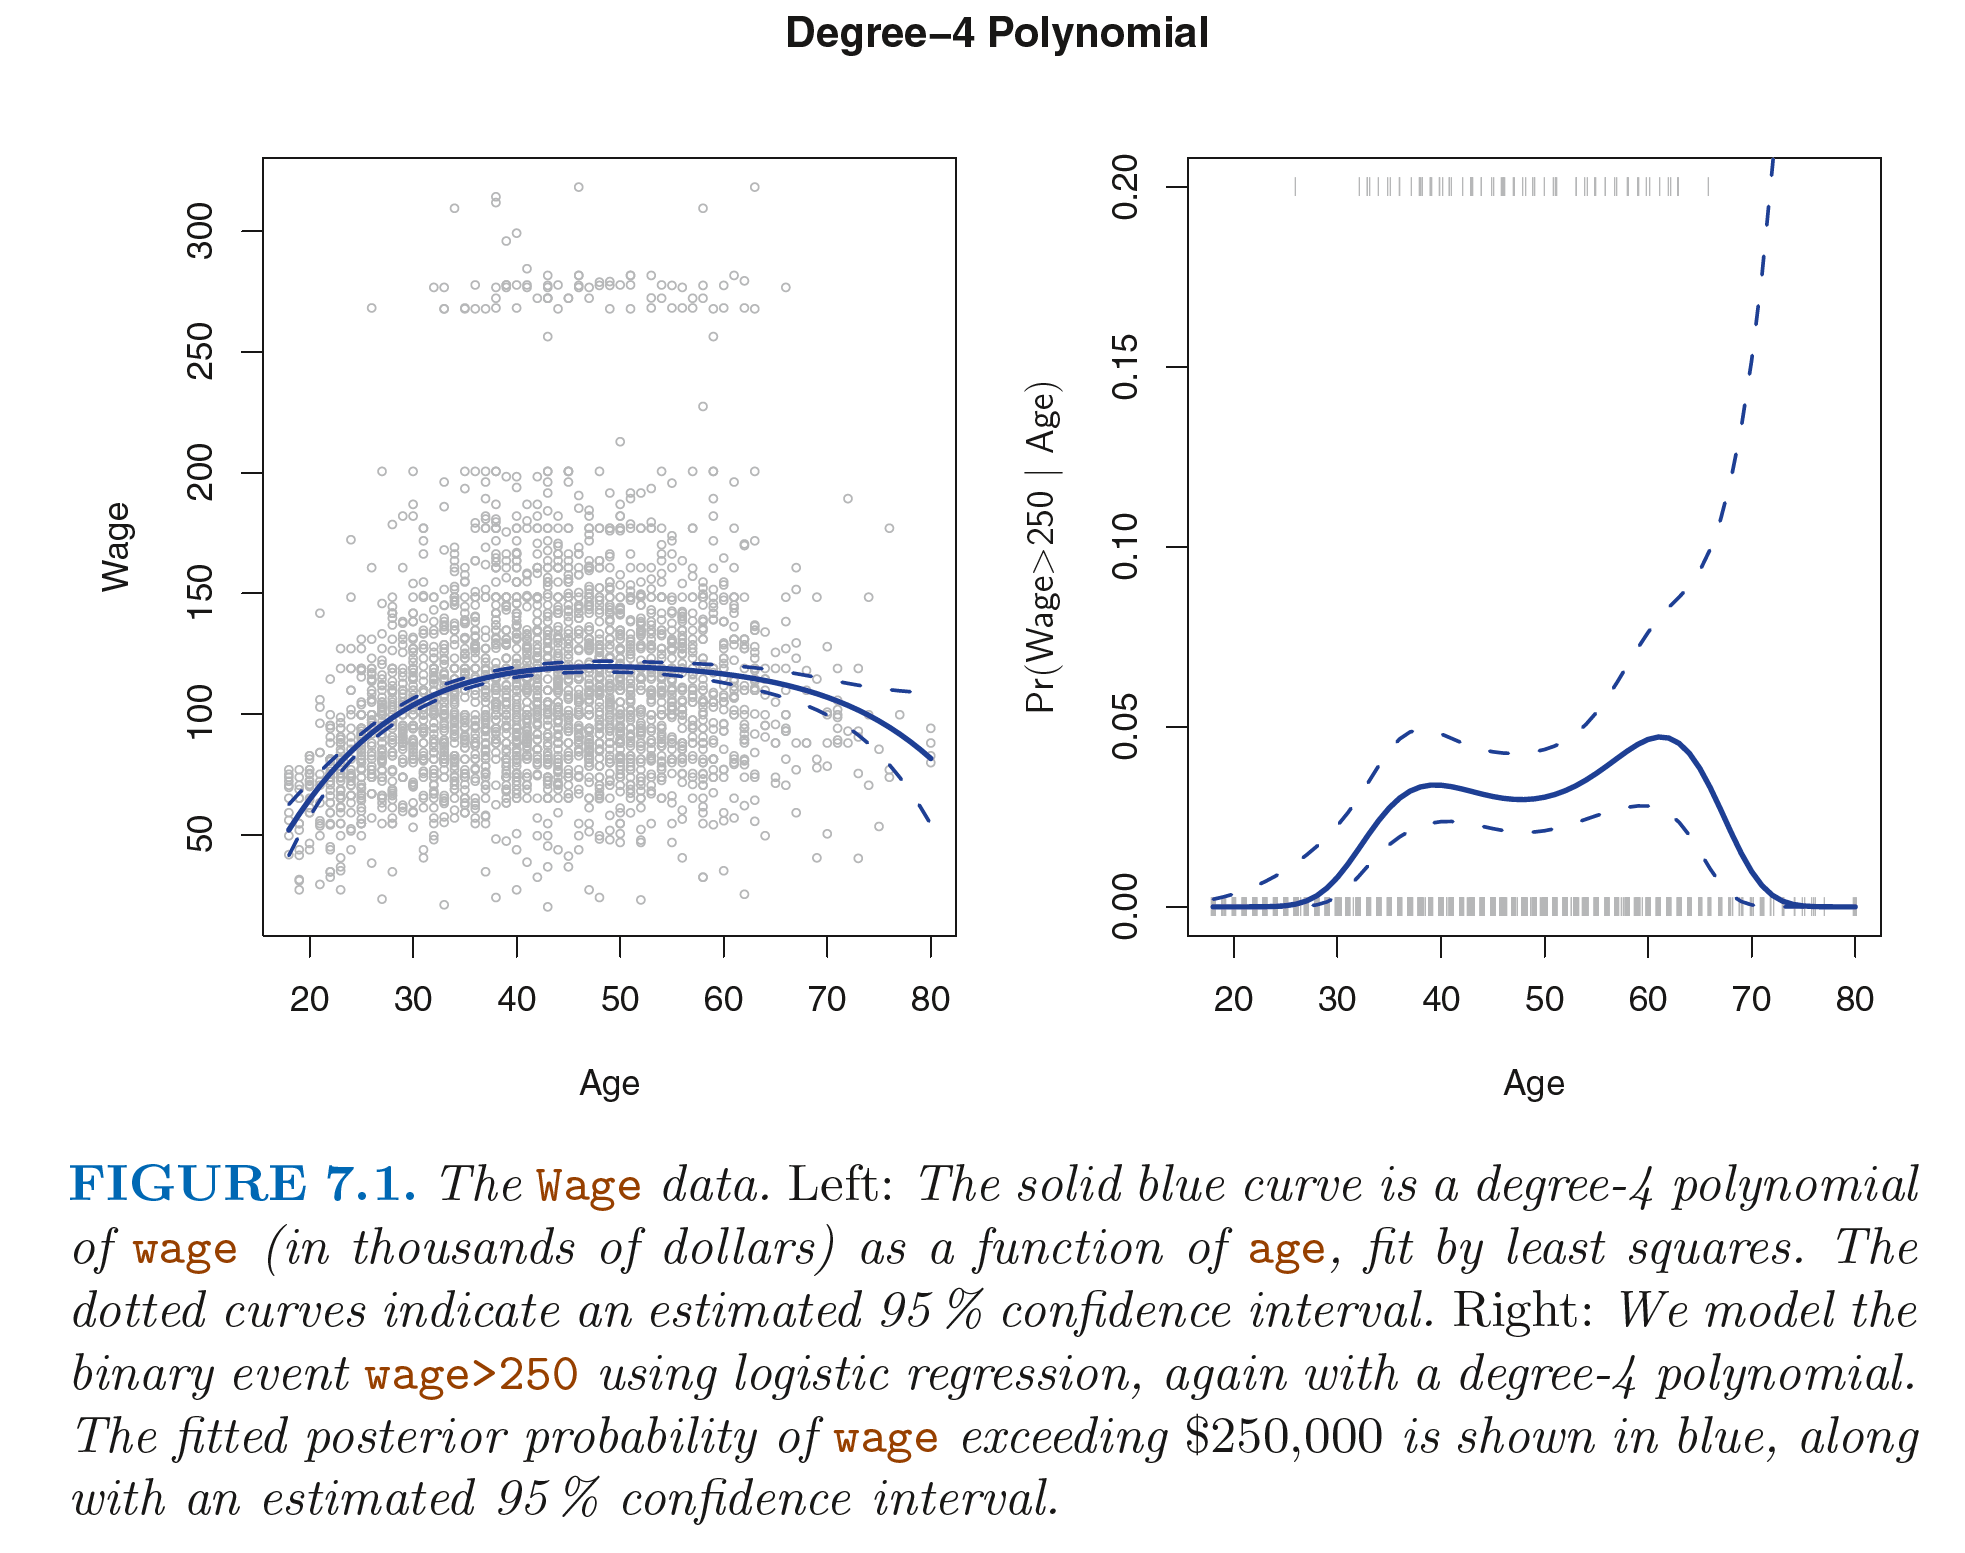

In [1]:
from IPython.display import Image
Image('images/pw52.png', width =700)

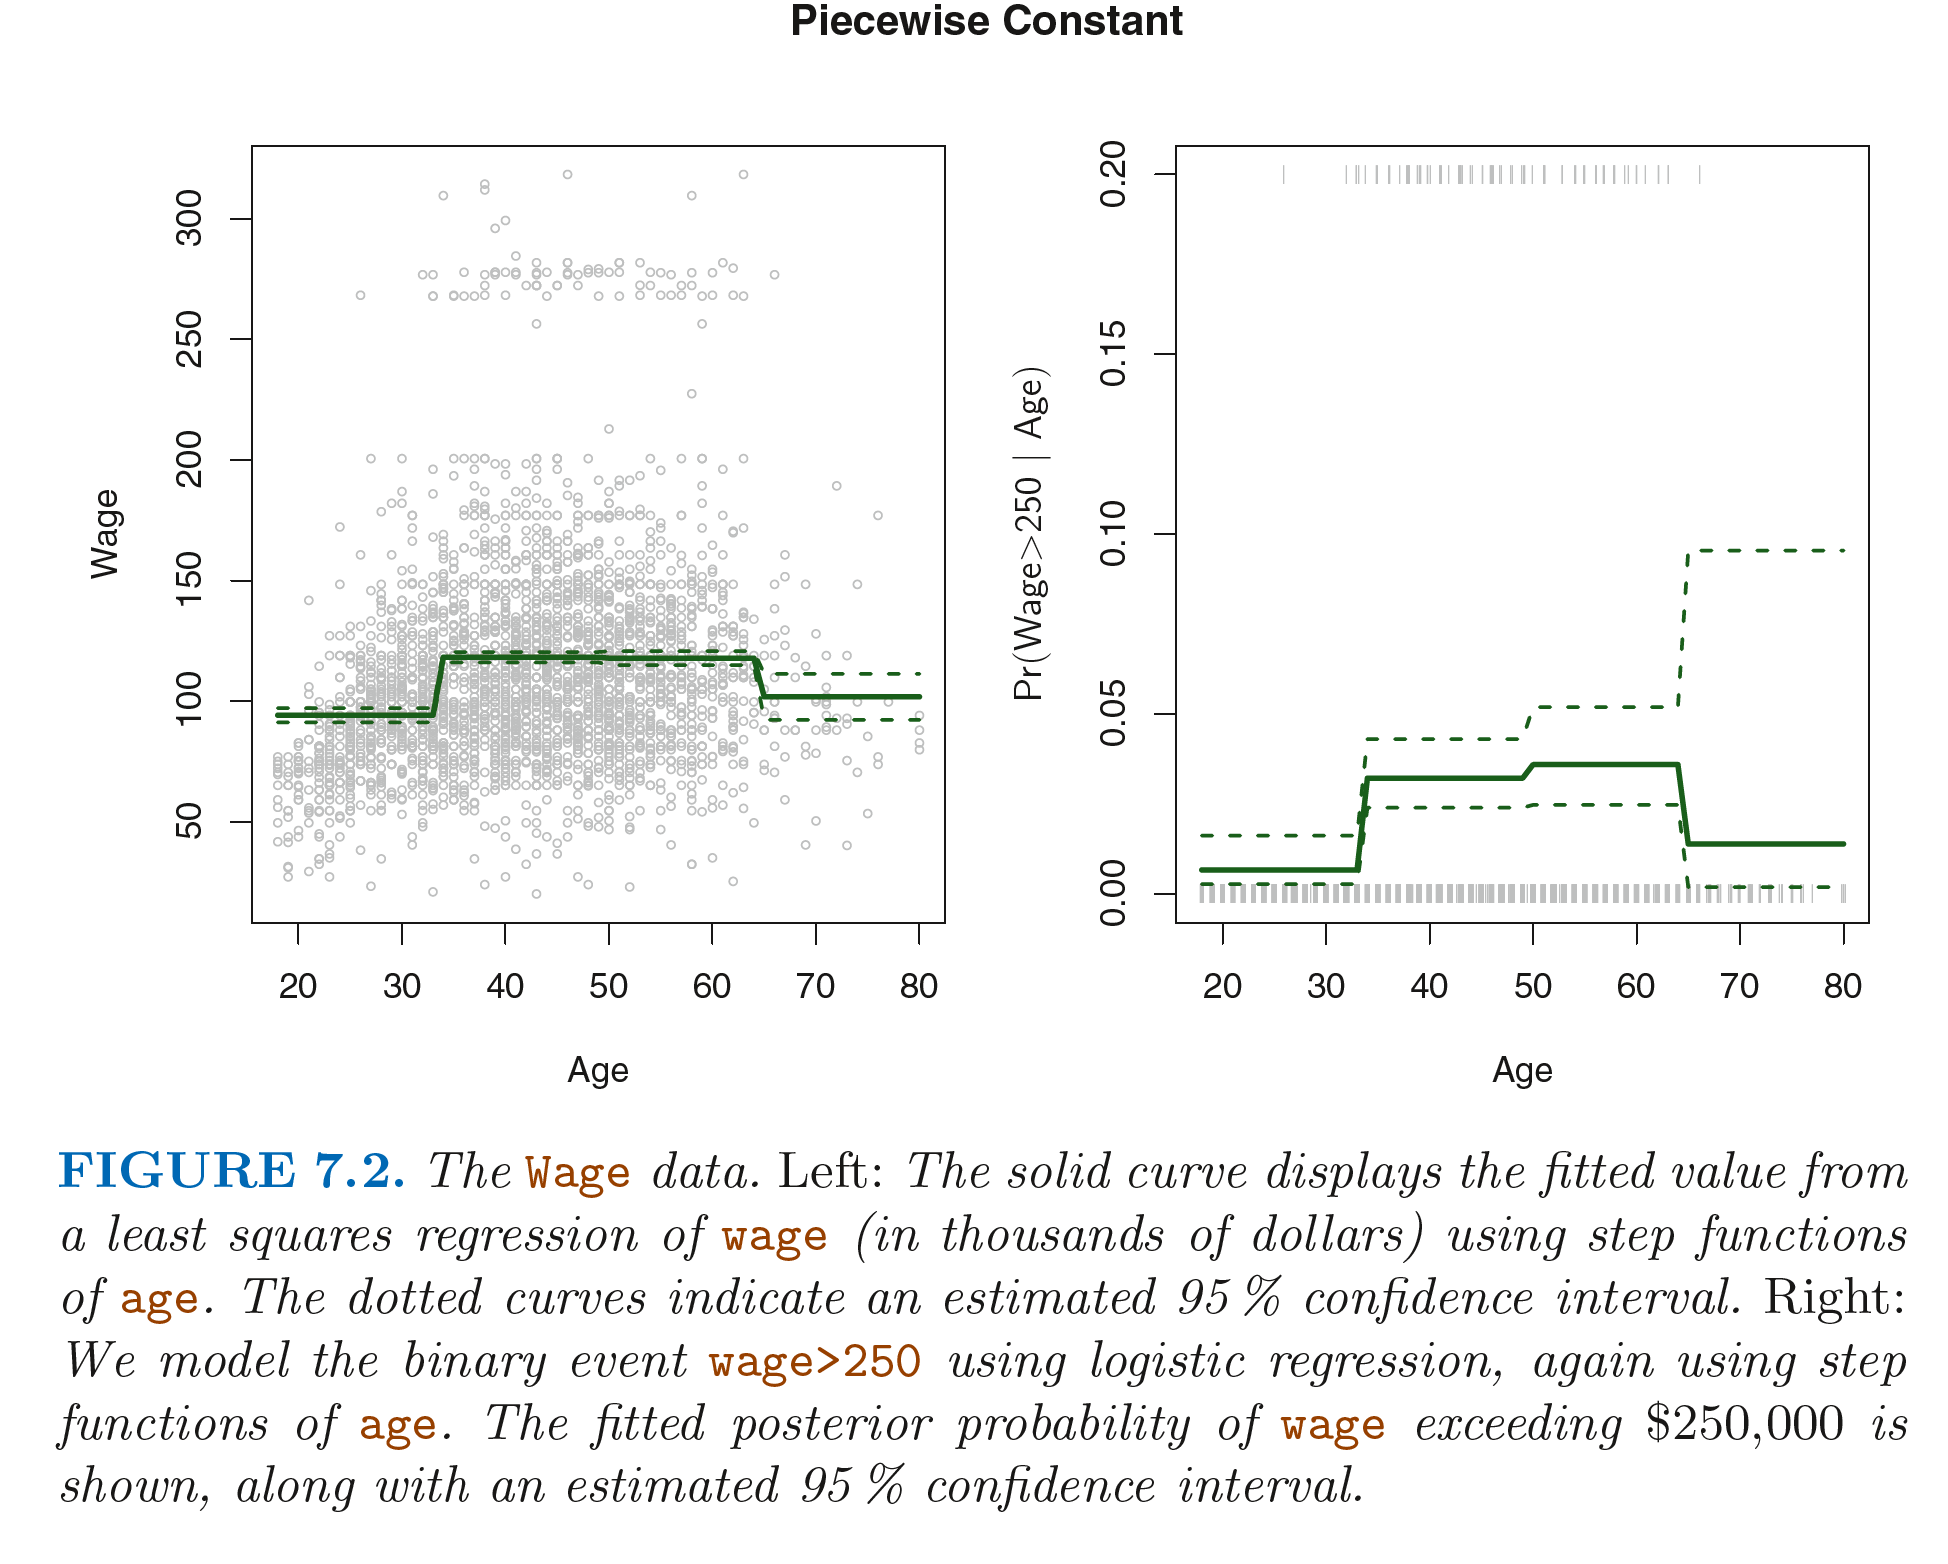

In [2]:
Image('images/pw53.png', width =700)

Figure 7.2 left side has 3 regions, and model is combined
-   <35
-   35-65
-   \>65

For right side;

$$y_i = \begin{cases}
\beta_{0} + \beta_{1x}  & \textrm{if }x_i\leq \alpha_1 \\
\beta_{2} + \beta_{3x}  & \textrm{if }\alpha_1 < x_i\leq \alpha_1 \\
\beta_{4} + \beta_{5x}  & \textrm{if }x_i > \alpha_1 \\
\end{cases}$$

In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline

Let explore how to generate the `Wage` dataset models:

In [4]:
df = pd.read_csv('data/wage.csv')
df.head(3)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


+ We first fit the polynomial regression model using the following commands:

In [5]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

will create a matrix of

$$
x^0, x^1, x^2, ..., x^n
$$

+ This syntax fits a linear model, using the `PolynomialFeatures()` function, in order to predict wage using up to a fourth-degree polynomial in `age`. 
+ The `PolynomialFeatures()` command allows us to avoid having to write out a long formula with powers
of `age`. 
+ We can then fit our linear model:

In [6]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


$x^4$ should be excluded if p-value < 0.05

However final model;
$$
\hat{y} = -184.15 + 21.25x - 0.56x^2 + 0.007x^3 - 0.00001x^4 
$$

In [25]:
fitz = sm.GLS(df.wage, X3).fit()
fitz.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-75.2439,22.184,-3.392,0.001,-118.741,-31.747
x1,10.1900,1.605,6.348,0.000,7.043,13.337
x2,-0.1680,0.037,-4.559,0.000,-0.240,-0.096
x3,0.0008,0.000,3.143,0.002,0.000,0.001


#### NOTES:

$$
\hat{y} = \beta_0+\beta_1x_1+ ... + \beta_4x_4
$$

+ Next, consider the task of predicting whether an individual earns more than \$250,000 per year. 
+ First, create the appropriate response vector, and then fit a logistic model using the `GLM()` function from `statsmodels`:

In [ ]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1}).to_numpy()

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial(sm.families.links.logit()))
res = clf.fit()

c:\Users\Hathim\anaconda3\envs\MSc3.10\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


+ Create a grid of values for `age` at which we want predictions, and then call the generic `predict()` function for each model:

In [33]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

+ Finally, plot the data and add the fit from the degree-4 polynomial.

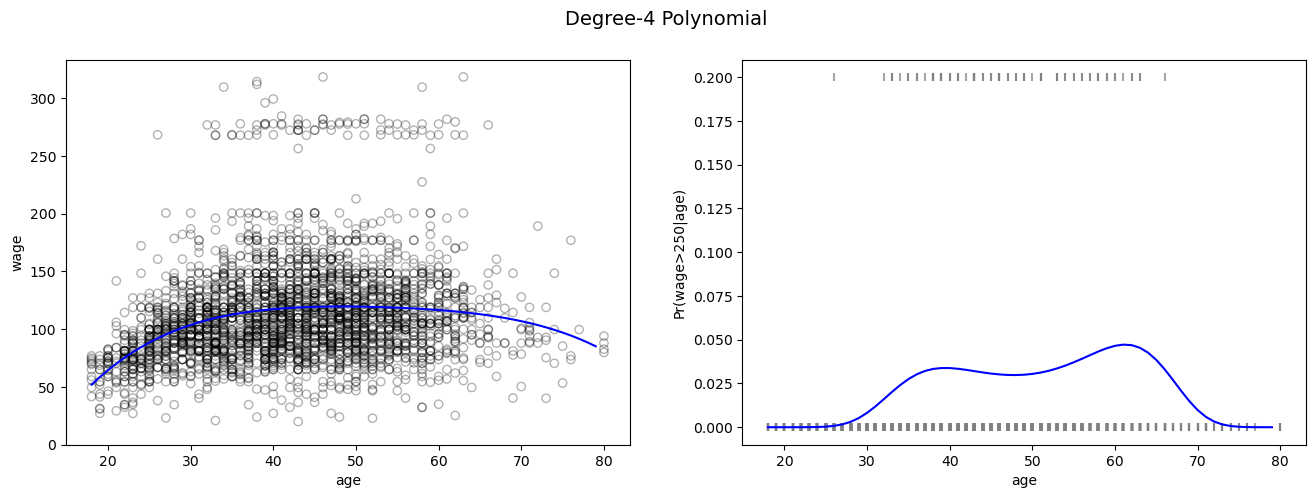

In [37]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)
ax1.set_xlabel('age')
ax1.set_ylabel('wage')

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')
plt.show()

### Deciding on a degree

+ In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. 
+ Now fit models ranging from linear to a degree-5 polynomial and  determine the simplest model which is sufficient to explain the relationship between `wage` and `age`.
+ Do this using the `anova_lm()` function, which performs an analysis of variance (ANOVA, using an F-test) in order to test the null hypothesis that a model $M_1$ is sufficient to explain the data against the  alternative hypothesis that a more complex model $M_2$ is required. 
+ In order to use the `anova_lm()` function, $M_1$ and $M_2$ must be **nested models**: the predictors in $M_1$ must be a subset of the predictors in $M_2$. 
+ In this case, we fit five different models and sequentially compare the simpler model to the more complex model 

(*Note:* you may get an *invalid value* Runtime Warning on the first model, because there is no "simpler model" to compare to):

#### NOTES:

$$y = 10x$$
$x$ increase by 1 unit, $y$ will increase by 10 <br>
$$y = 10x^2$$
$x^2$ increase by 1 unit, $y$ will increase by 10

higher order models will be harder to explain


$$
H_0 : \beta_1 = 0 \newline
H_1 : \beta_1 \not= 0
$$
if p-value < significant level, reject $H_0$

In [10]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


+ The $p$-value comparing the linear Model 1 to the quadratic Model 2 is essentially zero $(<10^{-32})$, indicating that a linear fit is not sufficient. 
+ Similarly the $p$-value comparing the quadratic Model 2 to the cubic Model 3 is very low (0.0017), so the quadratic fit is also insufficient. 
+ The $p$-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately 0.05 while the degree-5 polynomial Model 5 seems unnecessary because its $p$-value is 0.37. 
+ Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

## Step Functions
+ Also known as piecewise constant regression.
+ Cut $X$ into $K$ different regions and fit a constant to each region. 
$$y_i = \beta_0 + \beta_1C_1(x_i) + \beta_2C_2(x_i) + \ldots + \beta_KC_K(x_i) + \epsilon _i$$
where
$$\begin{align*}
 C_0(X) &= I(X<c_1) \\
 C_1(X) &= I(c_1 \leq X < c_2) \\
 & \vdots \\
 C_{K-1}(X) &= I(c_{K-1} \leq X < c_K) \\
 C_{K}(X) &= I(X \geq c_K) 
\end{align*}$$
+ The model reduces to $\hat{y} = \beta_0 + \beta_k$ where $k$ is the $k^\textrm{th}$ region. 
+ $\beta_0$ is just the estimate for y (the mean) in the region before the first cut point. 
+ Can use same approach for logistic regression to get a flat probability estimate for each region.

$$I = \begin{cases}
0  & \textrm{True }\\
1  & \textrm{False }
\end{cases}$$

### Example
+ In order to fit a step function, we use the `cut()` function:

In [38]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

age
(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: count, dtype: int64

+ Here `cut()` automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. 
+ We could also have specified our own cutpoints directly. 
+ Now let's create a set of dummy variables for use in the regression:

In [41]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,False,False,False
1,1.0,False,False,False
2,1.0,True,False,False
3,1.0,True,False,False
4,1.0,False,True,False
...,...,...,...,...
2995,1.0,True,False,False
2996,1.0,False,False,False
2997,1.0,False,False,False
2998,1.0,False,False,False


+ Now to fit the models. 
+ We dropped the `age<33.5` category, so the intercept coefficient can be interpreted as the average salary for those under 33.5 years of age. 
+ The other coefficients can be interpreted as the average additional salary for those in the other age groups. 

In [42]:
fit3 = sm.GLM(df_steps.wage.to_numpy(), df_steps_dummies.astype(int).to_numpy()).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
x1,24.0535,1.829,13.148,0.000,20.468,27.639
x2,23.6646,2.068,11.443,0.000,19.611,27.718
x3,7.6406,4.987,1.532,0.126,-2.135,17.416


#### NOTES

$$
\hat{y} = 94.15 + 24.05C_1 + 23.66C_2 + 7.64C_3
$$

$$
C_1 = I(33.5 < x \leq 49) \newline
C_2 = I(49 < x \leq 64.5) \newline
C_3 = I(64.5 < x \leq 80)
$$

let x = 40

$$ C_1 =
\begin{cases}
1  & 33.5 < x \leq 49 \\
0  & \textrm{elsewhere }
\end{cases}
$$

More bins will be more accurate but wil be tend to **overfitting**

+ The intercept coefficient of 94.160 can be interpreted as the average salary for those under 33.5 years of age. 
+ The other coefficients can be interpreted as the average additional salary for those in the other age groups.

c:\Users\Hathim\anaconda3\envs\MSc3.10\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


Text(0, 0.5, 'Pr(wage>250|age)')

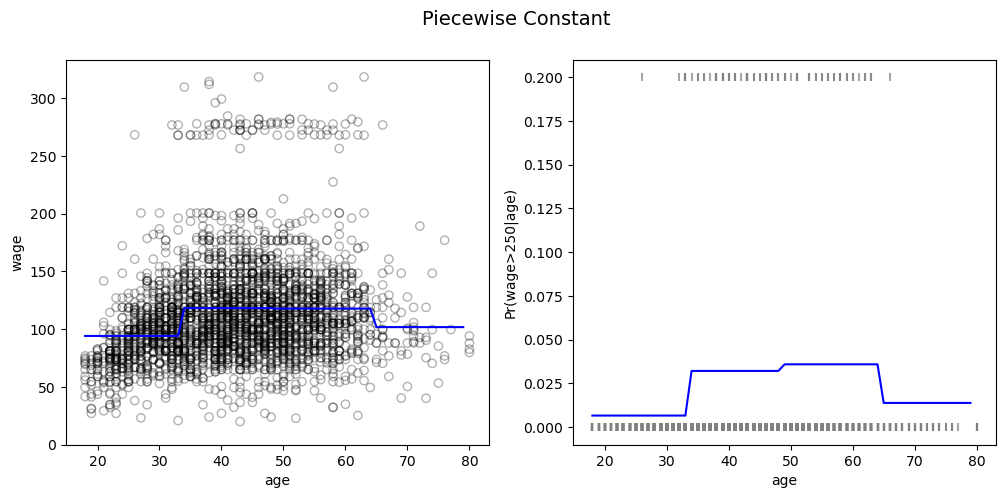

In [43]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1)).astype(int).to_numpy()

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(y, df_steps_dummies.astype(int).to_numpy(),
              family=sm.families.Binomial(sm.families.links.logit()))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

## Basis functions
+ Polynomial terms and step function are both types of basis functions. 
+ A basis function, $b_k(X)$, is a function that transforms $X$. 
$$y_i = \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + \ldots + \beta_Kb_K(x_i) + \epsilon _i$$
+ For polynomial regression, this is simply raising $X$ to a power and for step functions this is transforming $X$ into 0 or 1 based on whether $X$ is in a region or not (indicator variable). 
+ Wavelets and fourier series are also basis functions.

## Regression Splines
+ Combining piecewise constant regression and polynomial regression

### Piecewise polynomials
+ Fit separate low degree polynomials over different regions of $X$. 
+ It works by fitting a cubic regression model 
$$y_i = \beta_0 + \beta_1 x_i + \beta_2x_i^2 + \beta_3 x_i^3 + \epsilon_i$$
where the coefficients differ in different parts of the range $X$.
+ The place where the coefficients change are called knots. 
+ The polynomials are contrained so that they join smoothly at the knots.
+ Example of piecewise cubic polynomial with as single knot at point $c$:
$$y_i = \begin{cases}
\beta_{01} + \beta_{11} x_i + \beta_{21}x_i^2 + \beta_{31} x_i^3 + \epsilon_i & \textrm{if }x_i<c\\
\beta_{02} + \beta_{12} x_i + \beta_{22}x_i^2 + \beta_{32} x_i^3 + \epsilon_i & \textrm{if }x_i\geq c
\end{cases}$$





### Splines
+ Piecewise polynomials with constraints that the curves be continuous and smooth - meaning both first and second derivatives must match at the knot.
+ Fitting a spline turns out to be surprisingly simpler than it seems. 
+ We don't have to fit a 3 degree polynomial for each region. 
+ By smartly choosing basis functions, we can use least squares to solve for all the coefficients. 
+ We use the truncated power basis function which is 
$$
h(x, \xi) = \begin{cases}
(x -\xi)^3, & x > \xi \\
0 & \textrm{otherwise}
\end{cases}
$$ 
where $\xi$ is a knot.

+ The equation to send to least squares is 
$$
\hat{y} = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 +  b_1h(x, \xi_1) + \ldots + b_Kh(x, \xi_K)
$$ where we have $K$ truncated power transformations for a total of $K + 3$ predictors.

### How to choose K?
+ The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly.
+ It is common to place knots in a uniform fashion. 
+ One way to do this is to specify the desired d.o.f., and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.
+ Cross validation:
    + remove a portion of the data (say 10 %),
    + fit a spline with a certain number of knots to the remaining data, 
    + use the spline to make predictions for the held-out portion. 
    + repeat this multiple times until each observation has been left out once, and compute the overall cross-validated RSS. 
    + repeated for different numbers of knots K. 
    + the value of K giving the smallest RSS is chosen.
    
### Splines vs polynomial regression
+ Splines generally do better. 
+ A complex fit can still be fit well with a 3 degree spline by placing more knots.
+ It could take a very high degree polynomial to do the same and with worse variance.

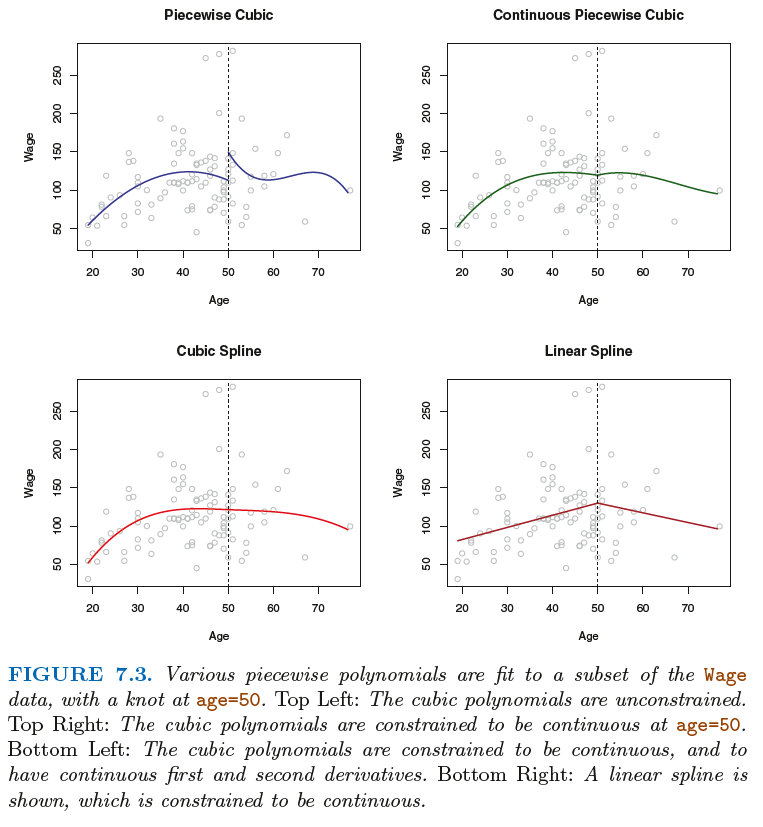

In [44]:
Image('images/pw54.png', width =700)

Great! Let's break down each spline or piecewise polynomial model into an equation form using:

* $\hat{y}$: predicted wage
* $x$: age
* $\beta_0, \beta_1, \beta_2, \ldots$: model coefficients
* $c$: knot (in this case, $c = 50$)

We’ll express each model using **basis functions**, so you can see how they differ.

---

### 🔹 1. **Piecewise Cubic (Unconstrained)**

You fit **two separate cubic polynomials** on each side of the knot:

$$
\hat{y} =
\begin{cases}
\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3, & \text{if } x \leq c \\
\gamma_0 + \gamma_1 x + \gamma_2 x^2 + \gamma_3 x^3, & \text{if } x > c
\end{cases}
$$

* $\beta$'s for age ≤ 50
* $\gamma$'s for age > 50
* No constraint at $x = 50$, so the function can jump

---

### 🔹 2. **Continuous Piecewise Cubic**

Same idea as above, but constrained to be **continuous at $x = 50$**:

$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 (x - c)_+ + \beta_5 (x - c)_+^2 + \beta_6 (x - c)_+^3
$$

Where:

* $(x - c)_+^k = (x - c)^k$ if $x > c$, else 0
* This is the **truncated power basis**

Continuity is enforced by including the **same base cubic**, and modifying it beyond the knot.

---

### 🔹 3. **Cubic Spline (Natural Spline)**

This is a **special case** of the above, with added constraints on derivatives:

$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \sum_{k=1}^{K} \gamma_k (x - \xi_k)_+^3
$$

Where:

* $\xi_k$ are knots (e.g., only $\xi_1 = 50$ here)
* The function and its first **and second derivatives** are constrained to be continuous
* Often called a **natural spline** if the function is linear at the boundaries (outside the knots)

---

### 🔹 4. **Linear Spline**

You use **two linear functions** joined at the knot:

$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 (x - c)_+
$$

* The second term only activates after $x > c$
* This introduces a **change in slope at the knot**, but keeps the function continuous

---

### 🧠 Example with $c = 50$

Let’s plug in:

```text
(x - 50)_+ = 0  if x ≤ 50
           = x - 50 if x > 50
```

So for a linear spline:

$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 \cdot (x - 50)_+
$$


## Smoothing splines
+ Finding a function that minimizes RSS but 'smooth'. 
+ Smoothness here is defined as having a relatively stable second derivative. 
+ We want to find the smoothing spline, $g$, that minimizes
$$\sum_{i=1}^n{(y_i - g(x_i))^2} + \lambda \int{g^{\prime \prime}(t)^2 dt}$$
+ The first term is a *loss function* that encourages g to fit the data well. 
+ The second term is a penalty term that penalize the variability in $g$.
+ Larger tuning parameter,$\lambda$, will make $g$ smoother.
+ The function that minimizes this error is a natural cubic spline with knots at each unique value of x but with shrunken parameter estimates due to the penalty term. 
+ The tuning (smoothing) parameter is very important to control variance. Choose smoothing parameter with CV.
+ Effective degrees of freedom, $df_\lambda$, is a measure of the flexibility of the smoothing spline (higher $df_\lambda$ -> more flexible(low bias, high variance)).



In [45]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

# Read in the data
df = pd.read_csv('data/wage.csv')

# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

+ In order to fit regression splines in python, we use the ${\tt dmatrix}$ module from the ${\tt patsy}$ library. 
+ Regression splines can be fit by constructing an appropriate matrix of basis functions. 
+ The ${\tt bs()}$ function generates the entire matrix of basis functions for splines with the specified set of knots.  
+ Fitting ${\tt wage}$ to ${\tt age}$ using a regression spline is simple:

In [46]:
# Fitting  wage  to  age  using a regression spline 

from patsy import dmatrix

# Specifying 3 knots
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(df.wage, transformed_x1).fit()
fit1.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

```python
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                         {"df.age": df.age}, return_type='dataframe')
```

This line uses **patsy’s `dmatrix()`** function to apply **B-spline basis expansion** to the `df.age` column. Here's a step-by-step explanation:

---
 🔧 Function Used: `dmatrix()`

`dmatrix()` from the **patsy** library creates a **design matrix** for regression-style formulas, similar to R.

---
 📐 Spline Formula: `"bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)"`

You're applying a **B-spline transformation**:

* `bs(...)`: Generates **B-spline basis functions**
* `df.age`: The variable being transformed (age column from `df`)
* `knots=(25, 40, 60)`: Places **internal knots** at ages 25, 40, and 60

  * These are the points where the spline is allowed to bend
* `degree=3`: You're using **cubic splines** (degree 3)
* `include_intercept=False`: Omits the constant column (intercept) from the design matrix

---
 📦 Data Supplied: `{"df.age": df.age}`

This is a dictionary that maps variable names in the formula string (`"df.age"`) to actual data (`df.age` Series from your DataFrame).

* You **must use the same name** (`"df.age"`) in the string and dictionary for `patsy` to evaluate it correctly.

---
 📋 Output Type: `return_type='dataframe'`

Returns a **Pandas DataFrame** of the transformed features (the spline basis matrix), instead of a NumPy array.

---
 🧠 What is the result?

You get a **new matrix of features** (basis functions) from the age variable, which are smooth, piecewise polynomial functions:

* These can model **non-linear relationships** in regression
* The matrix might have 6–8 columns depending on knots and degree

---
 ✅ Example Use Case

This is often used in **Generalized Additive Models (GAMs)** or flexible linear models like:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(transformed_x1, df['target'])
```

It helps model **non-linear trends** without manually transforming `age` (e.g., log, square).

---

Let me know if you want to visualize how the spline basis looks for a sample age range!


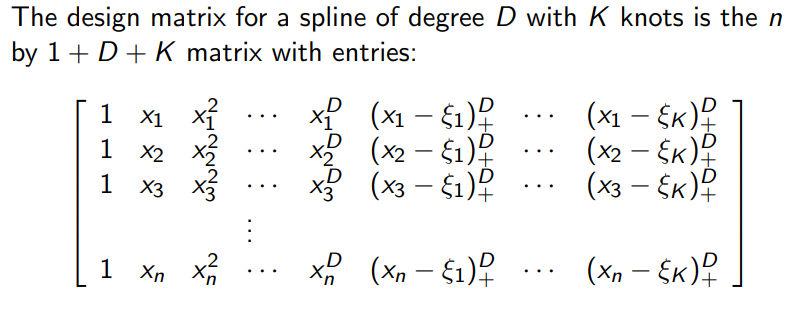

In [48]:
Image('images/pw57.png', width =600)


+ Here we have prespecified knots at ages 25, 40, and 60. 
+ This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.) 
+ We could also use the ${\tt df}$ option to produce a spline with knots at uniform quantiles of the data:

In [49]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          1594.0
Method:                          IRLS   Log-Likelihood:                -15314.
Date:                Wed, 07 May 2025   Deviance:                   4.7708e+06
Time:                        15:45:09   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09006
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               60.4937      9.460      6.394      0.000      41.952      79.036
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.9805     12.538      0.317      0.751     -20.593      28.554
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.6310      9.626      4.636      0.000      25.764      63.498
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.8388     10.755      5.843      0.000      41.759      83.919
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.9908     10.706      5.230      0.000      35.007      76.975
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.6881     14.402      3.520      0.000      22.461      78.915
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.6061     19.126      0.868      0.385     -20.881      54.093
========================================================================================================================================
"""

In [50]:
# Use the df  option to produce a spline with knots at uniform quantiles of the data:
# Specifying 6 degrees of freedom 

transformed_x2 = dmatrix("bs(df.age, df=6, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

Intercept                                       56.313841
bs(df.age, df=6, include_intercept=False)[0]    27.824002
bs(df.age, df=6, include_intercept=False)[1]    54.062546
bs(df.age, df=6, include_intercept=False)[2]    65.828391
bs(df.age, df=6, include_intercept=False)[3]    55.812734
bs(df.age, df=6, include_intercept=False)[4]    72.131473
bs(df.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

In [51]:
transformed_x2.head(10)

,Intercept,"bs(df.age, df=6, include_intercept=False)[0]","bs(df.age, df=6, include_intercept=False)[1]","bs(df.age, df=6, include_intercept=False)[2]","bs(df.age, df=6, include_intercept=False)[3]","bs(df.age, df=6, include_intercept=False)[4]","bs(df.age, df=6, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,0.537145,0.208308,0.017316,0.000000,0.000000,0.000000
2,1.0,0.000000,0.042161,0.751086,0.204676,0.002078,0.000000
3,1.0,0.000000,0.099937,0.780172,0.119815,0.000077,0.000000
4,1.0,0.000000,0.000195,0.529332,0.431076,0.039397,0.000000
5,1.0,0.000000,0.000000,0.344847,0.525756,0.128290,0.001107
6,1.0,0.000000,0.066950,0.772273,0.160162,0.000616,0.000000
7,1.0,0.324371,0.523603,0.138528,0.000000,0.000000,0.000000
8,1.0,0.000210,0.194417,0.747475,0.057897,0.000000,0.000000
9,1.0,0.000000,0.000000,0.430706,0.492480,0.076774,0.000041


In [52]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          1592.5
Method:                          IRLS   Log-Likelihood:                -15313.
Date:                Wed, 07 May 2025   Deviance:                   4.7662e+06
Time:                        15:45:54   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09101
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       56.3138      7.258      7.759      0.000      42.088      70.539
bs(df.age, df=6, include_intercept=False)[0]    27.8240     12.435      2.238      0.025       3.453      52.195
bs(df.age, df=6, include_intercept=False)[1]    54.0625      7.127      7.585      0.000      40.093      68.032
bs(df.age, df=6, include_intercept=False)[2]    65.8284      8.323      7.909      0.000      49.515      82.142
bs(df.age, df=6, include_intercept=False)[3]    55.8127      8.724      6.398      0.000      38.714      72.911
bs(df.age, df=6, include_intercept=False)[4]    72.1315     13.745      5.248      0.000      45.192      99.071
bs(df.age, df=6, include_intercept=False)[5]    14.7509     16.209      0.910      0.363     -17.018      46.519
================================================================================================================
"""

+ In this case python chooses knots which correspond to the 25th, 50th, and 75th percentiles of ${\tt age}$. 
+ The function ${\tt bs()}$ also has a ${\tt degree}$ argument, so we can fit splines of any degree, rather than the
default degree of 3 (which yields a cubic spline).

+ In order to instead fit a natural spline, we use the ${\tt cr()}$ function. 
+ Here we fit a natural spline with four degrees of freedom:

when `df=6` is specified in `bs(...)` but **knots are not explicitly set**, Python (via `patsy.bs()`) **automatically selects knot positions at default quantiles of the predictor** (i.e., `age`). However, the regression output **does not directly show the knot locations**, only the resulting basis functions.

### 🔍 Here's how it works behind the scenes:

When you specify:

```python
bs(age, df=6, include_intercept=False)
```

this means:

* You're asking for 6 **basis functions** (excluding the intercept),
* Internally, `patsy` selects **degree = 3 (cubic splines)** by default,
* And it places knots at **quantiles** of `age`, based on the formula:

  $$
  \text{Number of basis functions} = \text{degree} + \text{number of internal knots} + 1
  $$

So, if:

* `df=6`,
* and `degree=3` (default),
* then:

  $$
  \text{num internal knots} = df - degree - 1 = 6 - 3 - 1 = 2
  $$

But wait — in your model output you see 6 coefficients:

```text
bs(df.age, df=6, include_intercept=False)[0] to [5]
```

That matches the `df=6` setting.

### ✅ So how do you find the knot **locations**?

Since you didn't set them manually, they’re chosen automatically at **quantiles of age**.

Use this to **get the actual values** of those quantiles:

```python
import numpy as np

# Calculate percentiles for 25th, 50th, 75th
knots = np.percentile(df['age'], [25, 50, 75])
print("Automatic knots at:", knots)
```

This will output something like:

```python
Automatic knots at: [33.0 50.0 57.0]
```

These are the **internal knots** used to construct the 6 basis functions you're seeing in the GLM summary.

---

### 🧠 Summary:

* `df=6` means 6 basis functions are created.
* Knots are not shown in the model output — only the basis function coefficients.
* Use `np.percentile(df['age'], [25, 50, 75])` to uncover the **locations of the knots** chosen by default.


In [53]:
# To fit a natural spline, we use the  𝚌𝚛() function. 
# Specifying 4 degrees of freedom

transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

In [54]:
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1596.4
Method:                          IRLS   Log-Likelihood:                -15318.
Date:                Wed, 07 May 2025   Deviance:                   4.7827e+06
Time:                        15:46:48   Pearson chi2:                 4.78e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08766
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              79.6421      1.773     44.918      0.000      76.167      83.117
cr(df.age, df=4)[0]   -14.6678      3.436     -4.269      0.000     -21.402      -7.934
cr(df.age, df=4)[1]    36.8111      1.950     18.881      0.000      32.990      40.632
cr(df.age, df=4)[2]    35.9349      2.056     17.476      0.000      31.905      39.965
cr(df.age, df=4)[3]    21.5639      6.989      3.085      0.002       7.865      35.263
=======================================================================================
"""

+ As with the ${\tt bs()}$ function, we could instead specify the knots directly using the ${\tt knots}$ option.

+ Let's see how these three models stack up:

Text(0, 0.5, 'wage')

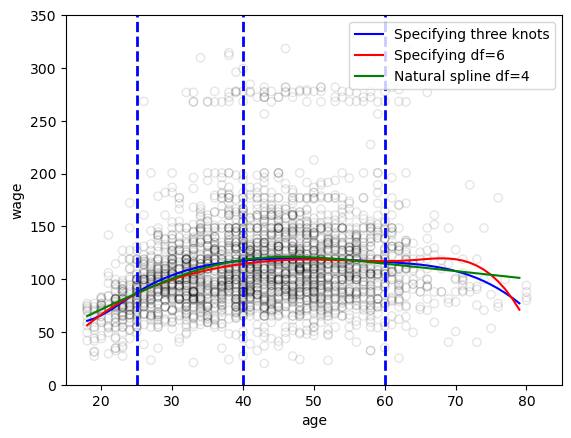

In [55]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

## Local Regression
+ Fits a new regression line to each point by using the nearest neighbors of that point. 
+ It uses **weighted least squares**, weighing points at the boundary and beyond 0 and points in the boundary a decreasing function of its distance to the point. 
+ Usually, small degree polynomials are fit to these local points. 
+ Need to choose weight function and span, $s$ of points. 
+ Larger span of points the smoother function you will get.
1. Gather the fraction, $s=k/n$ of training points whose $x_i$ are closest to $x_0$.
2. Assign a weight $K_{i0} = K(x_i, x_0)$ to each point in the neighbourhood. All but these $k$ nearest neighbors get weight zero.
3. Fit a weighted least squares regression of the $y_i$ on the $x_i$, by finding $\hat{\beta}_0$ and $\hat{\beta}_1$ that minimize
$$\sum_{i=1}^n{K_{i0}(y_i - \beta_0 - \beta_1x_i)^2} = \sum_{i=1}^n{K_{i0}(residuals)}$$
4. The fitted value at $x_0$ is $$\hat{f}(x_0) = \hat{\beta}_0 + \hat{\beta}_1x_0$$
+ Can even do local regression with pairs or more of variables but because of the curse of dimensionality, there might not be enough neighbors.



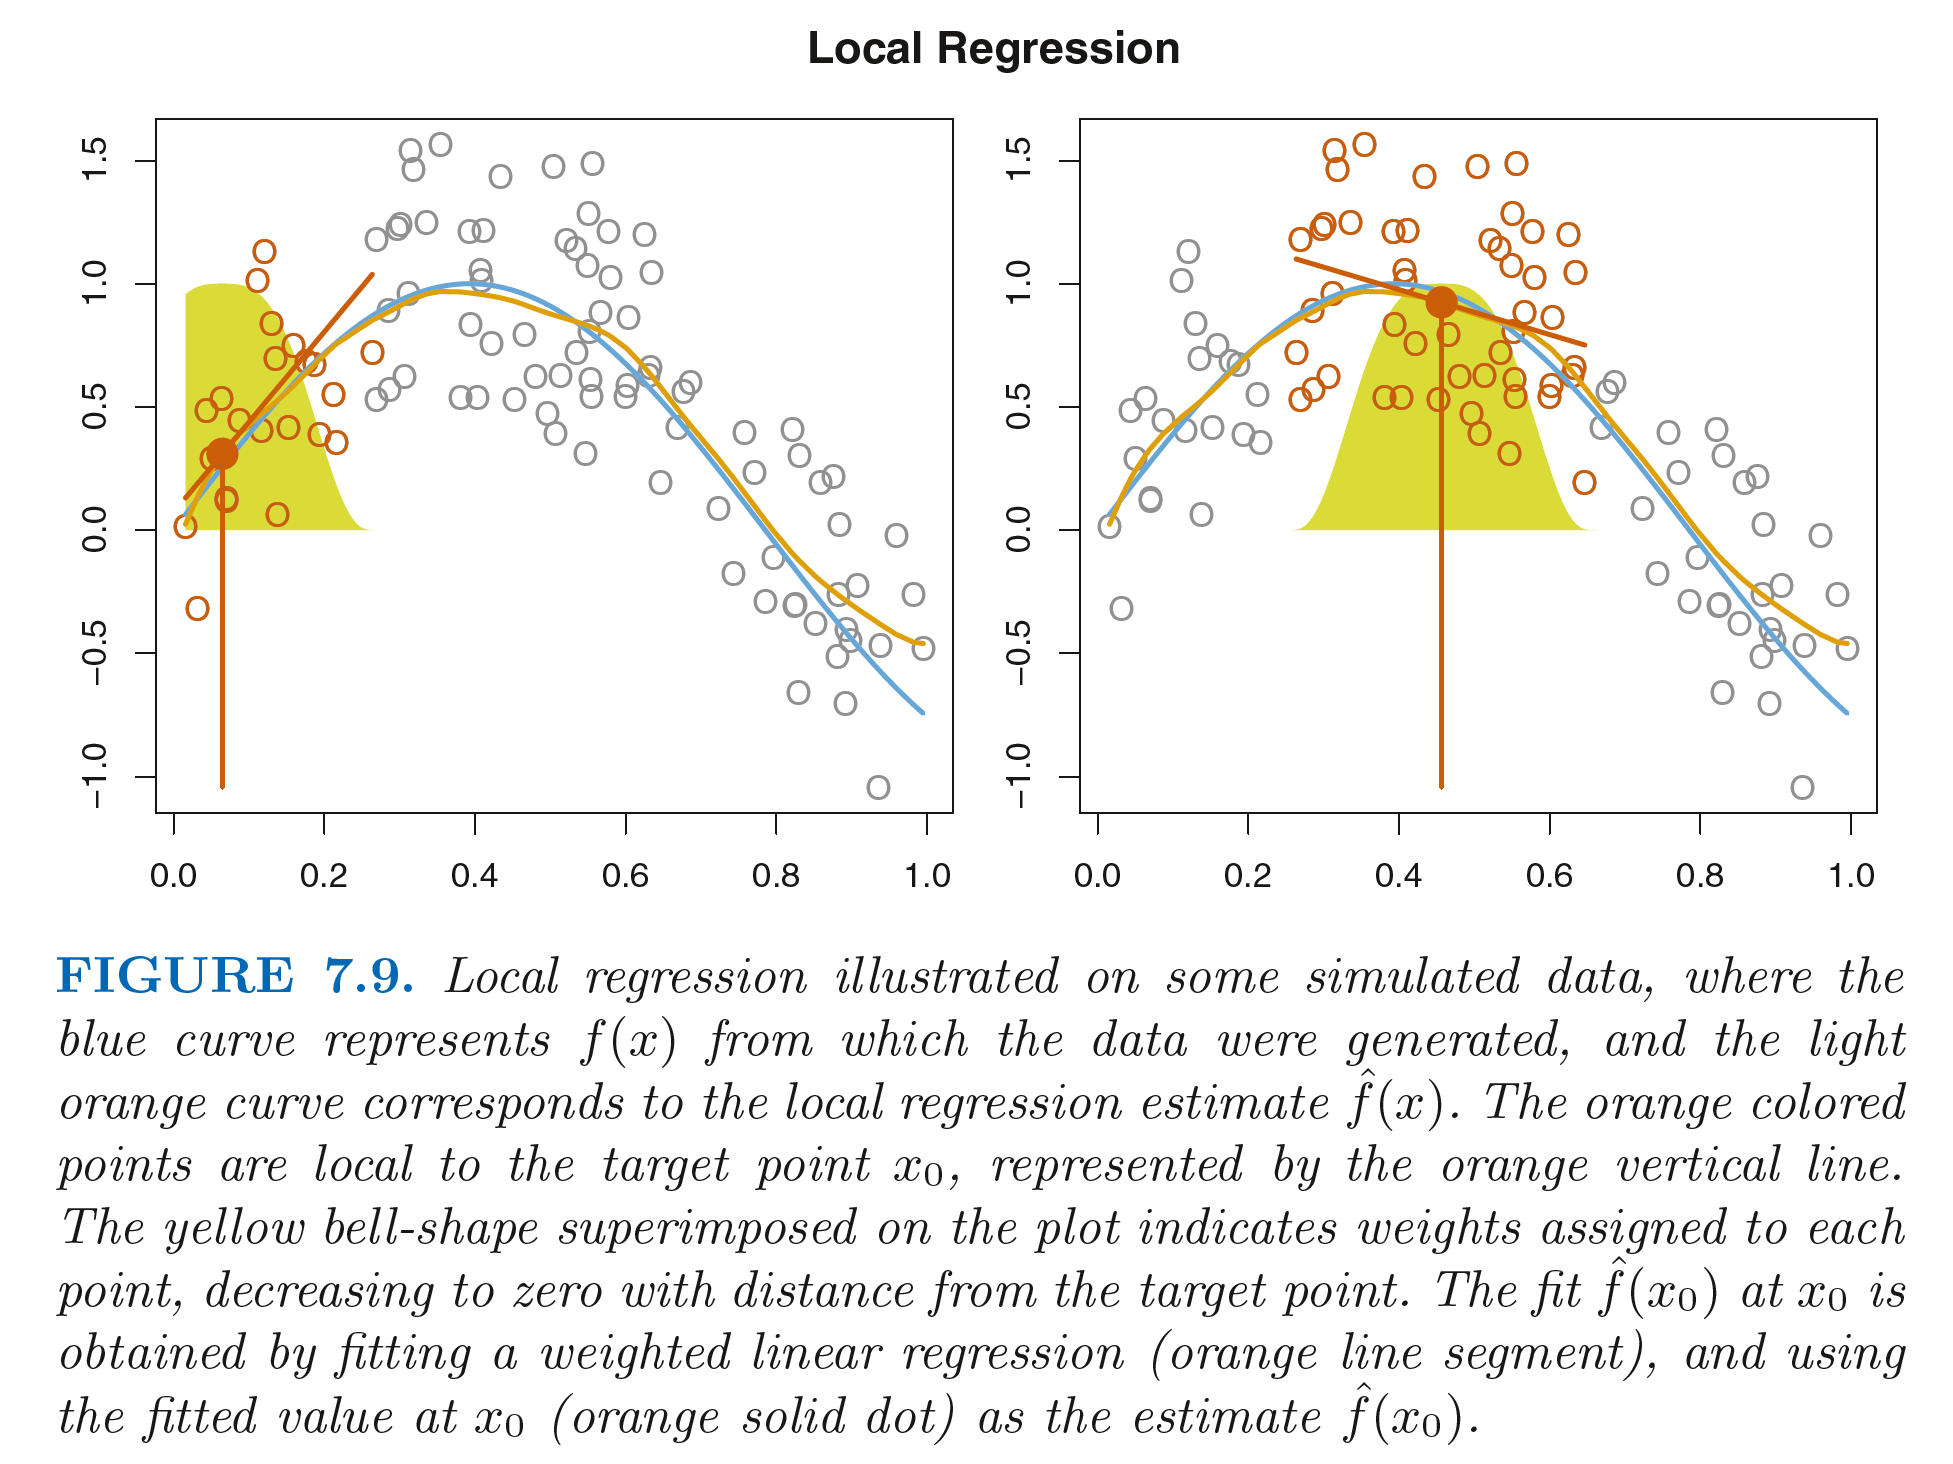

In [56]:
Image('images/pw55.png', width =700)

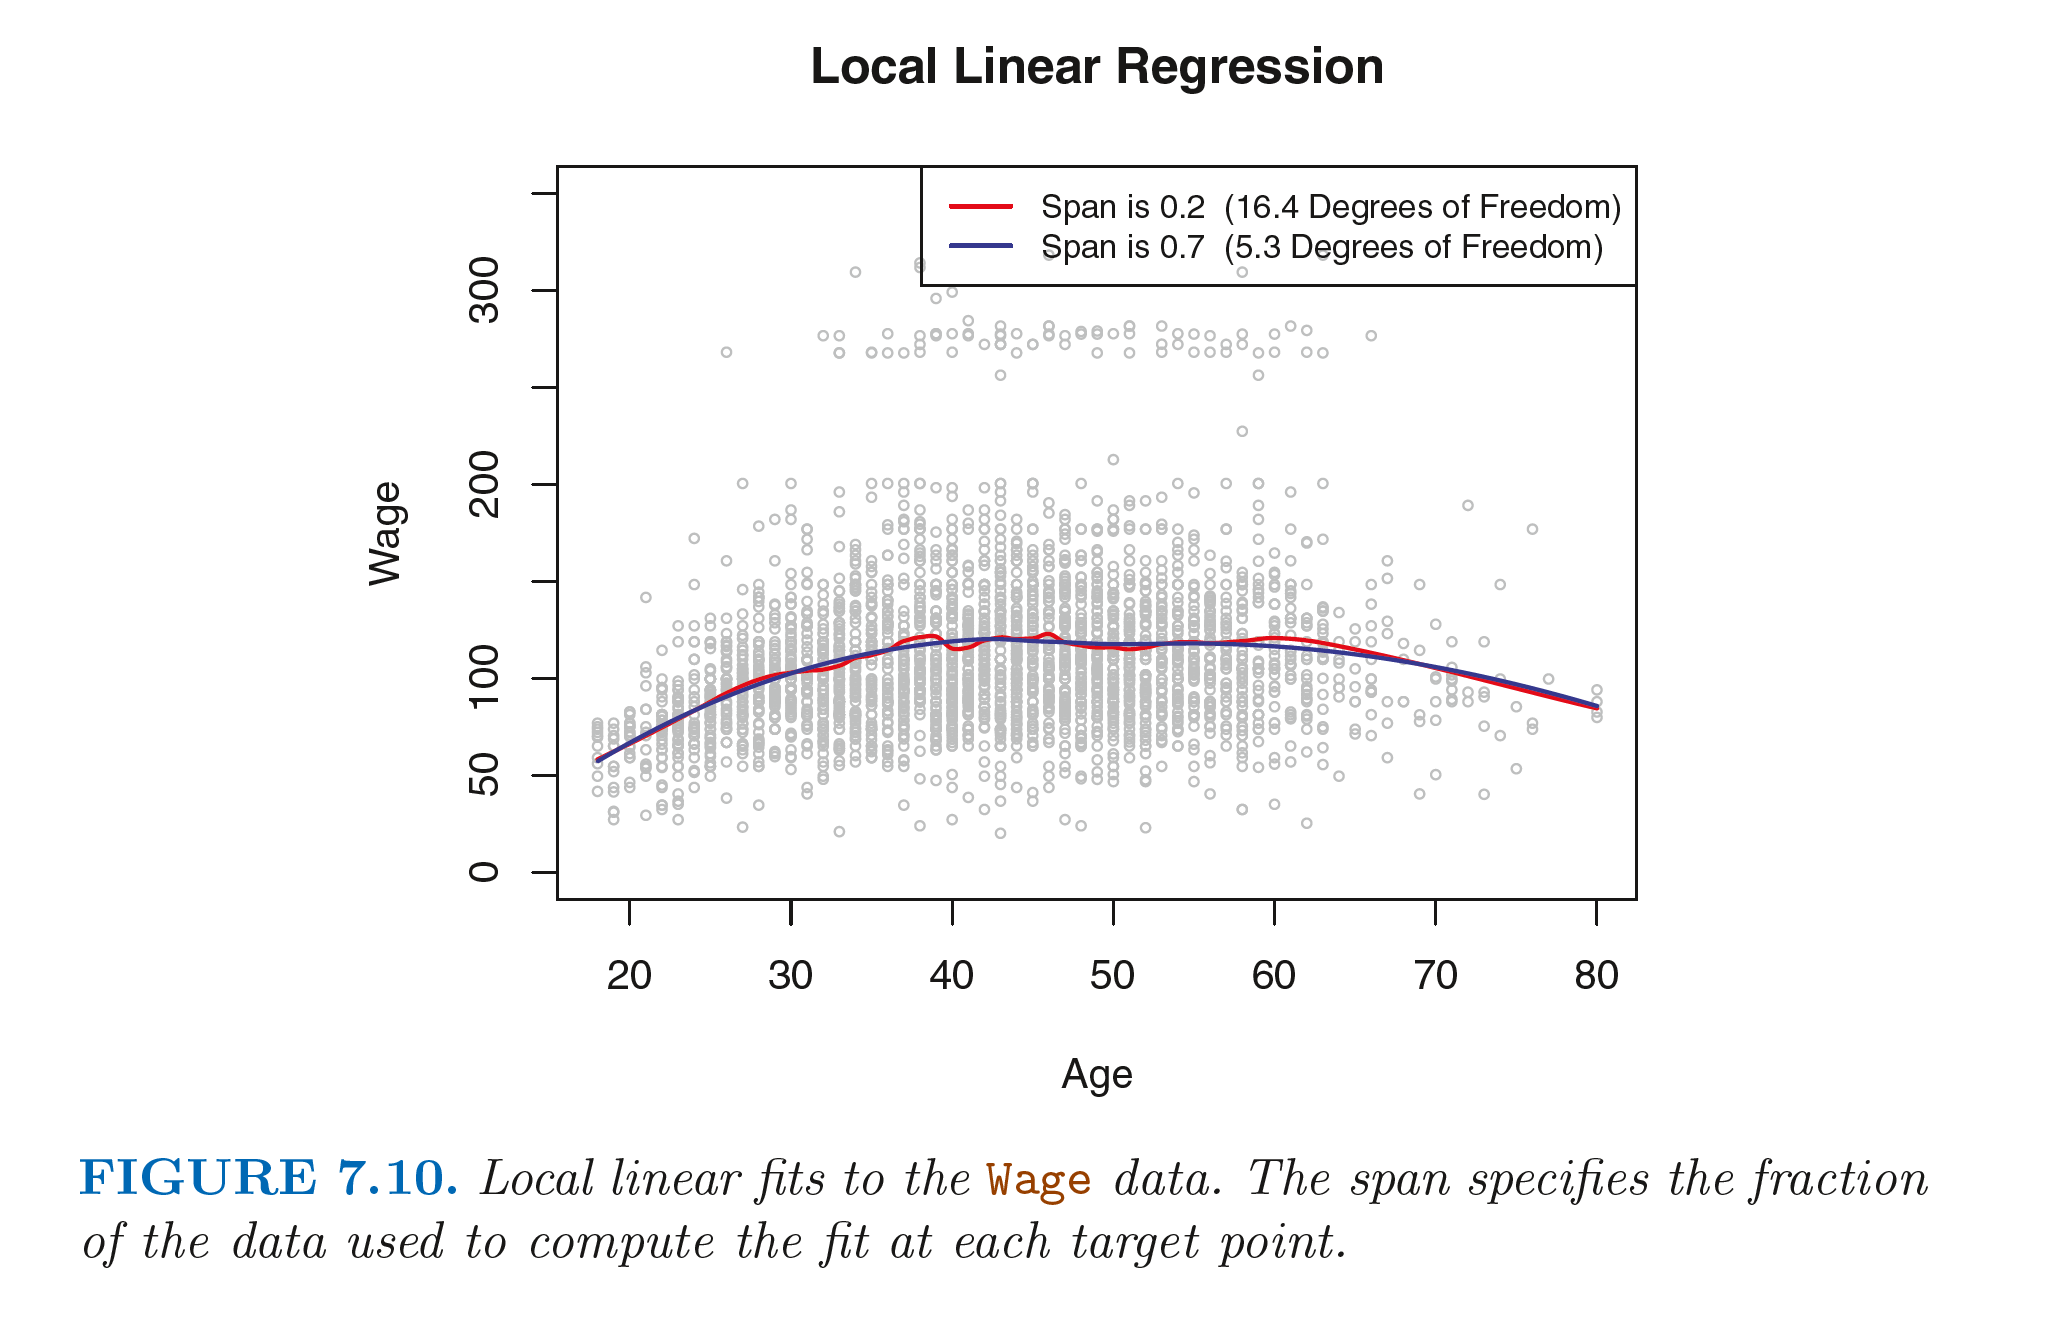

In [57]:
Image('images/pw56.png', width =700)

## General Additive Models
+ All the previous models all relate to single variable predictions. 
+ GAMs simply add different linear models above (like the ones above) for different variables in the model, allowing for multivariate regression/classification. 
+ Each variable gets its own model and is added together. 
+ Each own model is a building block for a GAM.

### GAM for regression
$$y_i = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \ldots + \beta_px_{ip} + \epsilon_i$$
+ Replace each linear component, $\beta_j x_{ij}$, with a smooth nonlinear function, $f_j (x_{ij})$,
$$ y_i = \beta_0 + f_1(x_{i1}) + \ldots + f_p(x_{ip}) + \epsilon_i$$
+ GAM can use the previous methods as building blocks for fitting an additive model.
+ The main limitation of GAMs is that the model is restricted to be additive. With many variables, important interactions can be missed.
+ However, we can manually add interaction terms by including additional predictors of the form $X_j \times X_k$. 
+ Or, we can add low-dimensional interaction functions of the form $f_{jk}(X_j,X_k)$ into the model using two-dimensional smoothers such as local regression, or two-dimensional splines.
+ The same technique can also be used for classification problems.



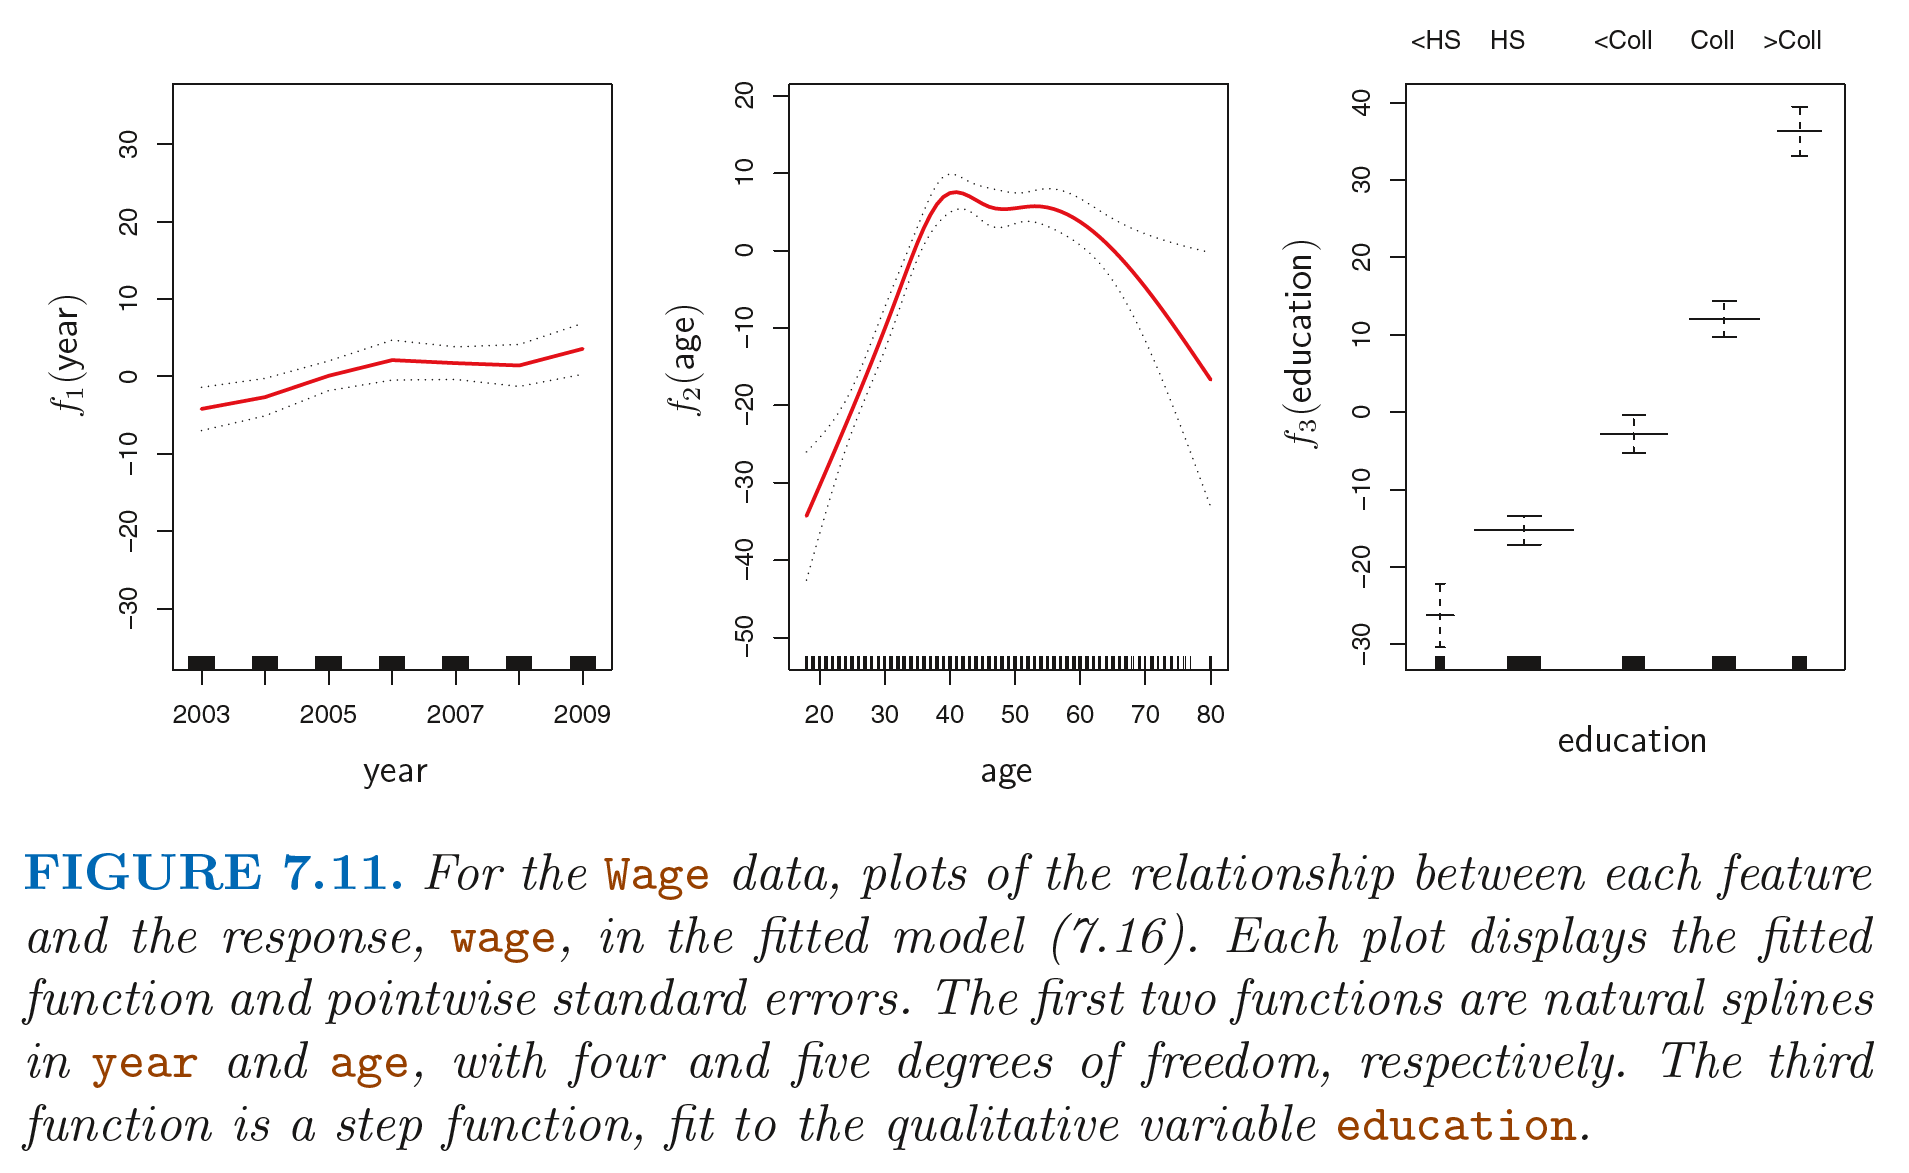

In [58]:
Image('images/pw58.png', width =700)

# Lab 7.8.1
Recreating plot 7.1

In [59]:
import pandas as pd
import numpy as np

In [60]:
wage = pd.read_csv("data/wage.csv")

In [61]:
# Use sklearn to get regression coefficients
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [62]:
poly = PolynomialFeatures(degree=4, include_bias=False)

In [63]:
X = wage[['age']]
y = wage['wage']

In [64]:
model = LinearRegression()

In [65]:
model.fit(poly.fit_transform(X), y)

LinearRegression()

In [66]:
# Coefficients are the same as in ISLR
model.intercept_, model.coef_

(np.float64(-184.15417977322),
 array([ 2.12455205e+01, -5.63859313e-01,  6.81068771e-03, -3.20383037e-05]))

In [67]:
model.intercept_

np.float64(-184.15417977322)

### Standard error in  Scikit-learn
Sklearn doesn't supply the standard error so you'll have to write the formula yourself or use statsmodels

In [68]:
import statsmodels.formula.api as smf

In [69]:
results = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()

In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Wed, 07 May 2025   Prob (F-statistic):           2.77e-57
Time:                        16:21:52   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -184.1542     60.040     -3.067      0.002    -301.879     -66.430
age                 21.2455      5.887      3.609      0.000       9.703      32.788
np.power(age, 2)    -0.5639      0.206     -2.736      0.006      -0.968      -0.160
np.power(age, 3)     0.0068      0.003      2.221      0.026       0.001       0.013
np.power(age, 4) -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
results.bse

Intercept           60.040377
age                  5.886748
np.power(age, 2)     0.206108
np.power(age, 3)     0.003066
np.power(age, 4)     0.000016
dtype: float64

In [72]:
results.conf_int()

,0,1
Intercept,-301.878732,-6.642963e+01
age,9.703041,3.278800e+01
"np.power(age, 2)",-0.967987,-1.597312e-01
"np.power(age, 3)",0.000799,1.282223e-02
"np.power(age, 4)",-0.000064,1.447431e-07


### Confidence interval for the mean
There are different confidence intervals for the mean (the regression line) and prediction. Prediction intervals are going to be much wider. The regression line will not wiggle around so much

In [73]:
from statsmodels.stats.outliers_influence import summary_table

In [74]:
st, data, ss2 = summary_table(results, alpha=0.05)

In [75]:
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

In [76]:
order = np.argsort(X.values.flatten())
x_o = X.values.flatten()[order]

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

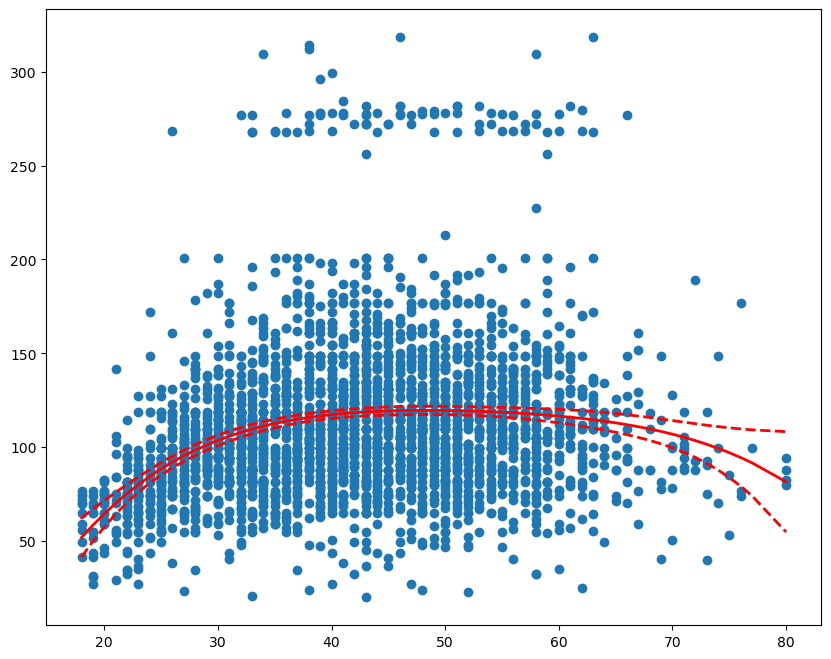

In [78]:
plt.figure(figsize=(10, 8))
plt.scatter(x_o, y[order])
plt.plot(x_o, fittedvalues[order], 'r', lw=2)
plt.plot(x_o, predict_mean_ci_low[order], 'r--', lw=2)
plt.plot(x_o, predict_mean_ci_upp[order], 'r--', lw=2)

In [79]:
# Which features are necessary
smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Wed, 07 May 2025   Prob (F-statistic):           2.77e-57
Time:                        16:26:50   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -184.1542     60.040     -3.067      0.002    -301.879     -66.430
age                 21.2455      5.887      3.609      0.000       9.703      32.788
np.power(age, 2)    -0.5639      0.206     -2.736      0.006      -0.968      -0.160
np.power(age, 3)     0.0068      0.003      2.221      0.026       0.001       0.013
np.power(age, 4) -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Use Anova to test wheter each additional polynomial term is significant
Models must be nested here, meaning that mod2 must be a superset of mod1

In [80]:
from statsmodels.stats.api import anova_lm

In [81]:
mod1 = smf.ols('wage ~ age', data=wage).fit()
mod2 = smf.ols('wage ~ age + np.power(age, 2)', data=wage).fit()
mod3 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3)', data=wage).fit()
mod4 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()
mod5 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4) + np.power(age, 5)', data=wage).fit()

In [82]:
# Same as ISLR
# polynomial terms 4 and 5 are not needed. p > .05
anova_lm(mod1, mod2, mod3, mod4, mod5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


# Logistic regression
Prediciton of greater than 250k in income

In [83]:
wage['wage_250'] = (wage['wage'] > 250) * 1

In [84]:
results = smf.logit('wage_250 ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


In [85]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               wage_250   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.04013
Time:                        16:27:01   Log-Likelihood:                -350.61
converged:                       True   LL-Null:                       -365.27
Covariance Type:            nonrobust   LLR p-value:                 6.747e-06
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -109.5530     47.655     -2.299      0.022    -202.956     -16.150
age                  8.9950      4.187      2.148      0.032       0.789      17.201
np.power(age, 2)    -0.2816      0.135     -2.081      0.037      -0.547      -0.016
np.power(age, 3)     0.0039      0.002      2.022      0.043       0.000       0.008
np.power(age, 4) -1.949e-05   9.91e-06     -1.966      0.049   -3.89e-05   -6.41e-08
====================================================================================
"""

In [86]:
y_hat = np.exp(results.fittedvalues)
y = wage['wage_250'].values
x = X['age'].values
x_mean = x.mean()
n = len(y)

In [87]:
sy = np.sqrt(np.sum((y - y_hat)**2) / (n - 2))
sx = np.sum((x - x_mean) ** 2) / n
x_s = (x - x_mean) ** 2

In [88]:
sx = np.sum(x ** 2) - (x.sum() ** 2) / n

In [89]:
err = sy * np.sqrt(1/n + x_s / x_s.sum())

In [90]:
order = np.argsort(x)
x_o = x[order]

(0.0, 0.07)

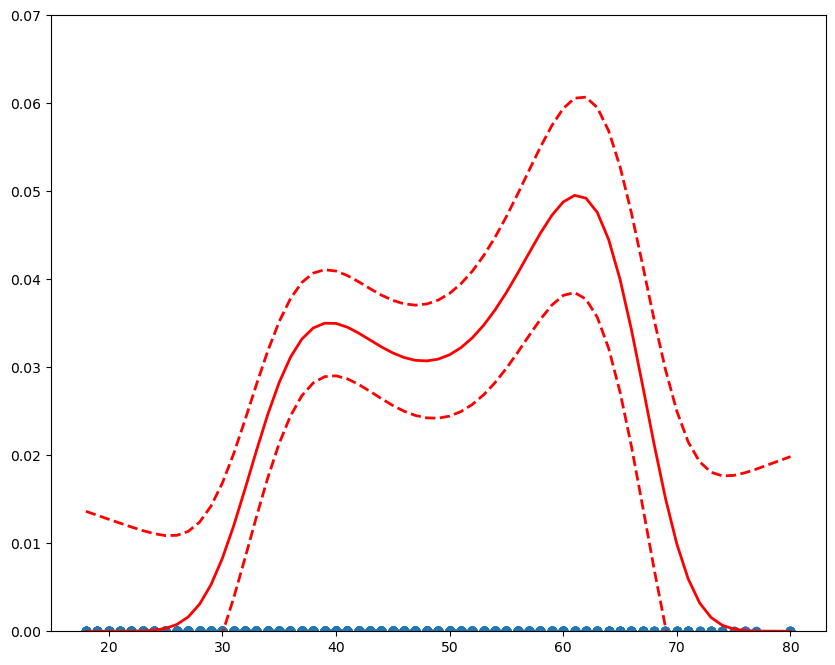

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(x_o, y[order])
plt.plot(x_o, y_hat[order], 'r', lw=2)
plt.plot(x_o, y_hat[order] + 2 * err[order], 'r--', lw=2)
plt.plot(x_o, y_hat[order] - 2 * err[order], 'r--', lw=2)
plt.ylim(0, .07)

# Step function as in 7.2
use pd.cut

In [ ]:
results = smf.ols('wage ~ pd.cut(age, 4)', data=wage).fit()

In [ ]:
results.summary()

# Splines

In [ ]:
import scipy.interpolate as si

In [ ]:
y = wage['wage'].values

In [ ]:
order = np.argsort(x)

In [ ]:
x_sort = x[order]
y_sort = y[order]
t = np.array([25, 40, 60])

In [ ]:
spl = si.LSQUnivariateSpline(x_sort, y_sort, t)

In [ ]:
spl(x_sort)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(x_sort, y_sort, 'ro', ms=5)
plt.plot(x_sort, spl(x_sort), 'g-', lw=3);

## General additive models for classification


In [ ]:
pip install pygam --user


This data contains 569 observations and 30 features. The target variable in this case is whether the tumor of malignant or benign, and the features are several measurements of the tumor. For showcasing purposes, we keep the first 6 features only.

In [ ]:
import pandas as pd        
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer

#load the breast cancer data set
data = load_breast_cancer()

#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

Since this is a classification problem, make sure to use pyGam’s LogisticGAM() function.

In [ ]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df

#Fit a model with the default parameters
gam = LogisticGAM().fit(X, y)

In [ ]:
gam.summary()

In [ ]:
gam.accuracy(X, y)

In [ ]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[:, 1], c='grey', ls='--')
    ax.set_title(titles[i])
plt.show()

### GAM for regression

In [ ]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [ ]:
gam.summary()

More on this: https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Functional-Form:

# KNN Regression

https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

wage = pd.read_csv("data/wage.csv")

from sklearn.model_selection import train_test_split
train , test = train_test_split(wage, test_size = 0.3)

X_train = train[['age']]
y_train = train['wage']
X_test = test[['age']]
y_test = test['wage']

In [93]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=9)

In [94]:
y_pred_knn=knn.predict(X_test)


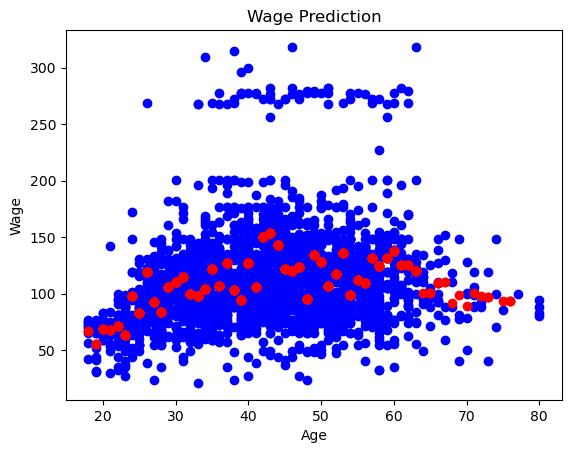

In [95]:
plt.scatter(X_train,y_train,color="blue")
plt.scatter(X_test,knn.predict(X_test),color="red")
plt.title("Wage Prediction")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.show()

In [96]:
from sklearn import neighbors
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_val = [] #to store rmse values for different k
for K in range(100):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train) #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print("RMSE value for k= " , K , "is:", error)

RMSE value for k=  1 is: 50.718973069890524
RMSE value for k=  2 is: 49.292318332031094
RMSE value for k=  3 is: 45.52443654988202
RMSE value for k=  4 is: 45.93366070592222
RMSE value for k=  5 is: 44.22761627231504
RMSE value for k=  6 is: 42.84939088583738
RMSE value for k=  7 is: 42.039202835202246
RMSE value for k=  8 is: 42.401656316906035
RMSE value for k=  9 is: 42.000541839564086
RMSE value for k=  10 is: 41.12728021652176
RMSE value for k=  11 is: 40.88138332127692
RMSE value for k=  12 is: 40.89821245643968
RMSE value for k=  13 is: 40.60115886062252
RMSE value for k=  14 is: 40.50414541915081
RMSE value for k=  15 is: 40.2047428850867
RMSE value for k=  16 is: 40.31087486288103
RMSE value for k=  17 is: 40.35632958497718
RMSE value for k=  18 is: 40.298766367862804
RMSE value for k=  19 is: 40.354884045099965
RMSE value for k=  20 is: 40.31442443211717
RMSE value for k=  21 is: 40.14213125615673
RMSE value for k=  22 is: 40.00595814638985
RMSE value for k=  23 is: 39.966570

Text(0.5, 1.0, 'RMSE vs K value')

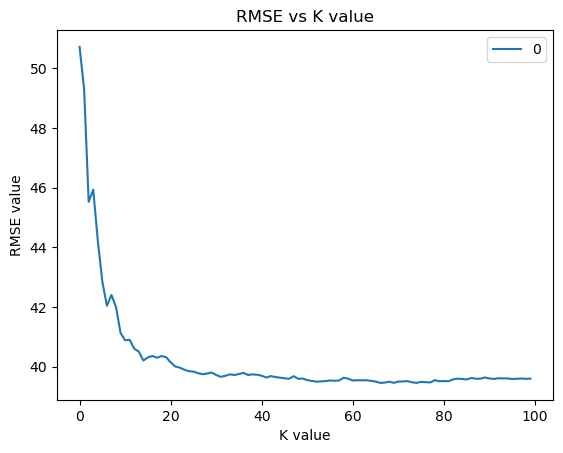

In [98]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve
curve.plot()
plt.xlabel("K value")
plt.ylabel("RMSE value")
plt.title("RMSE vs K value")

In [102]:
from sklearn.model_selection import GridSearchCV
params = {"n_neighbors":list(range(1,100))}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
model.fit(X_train,y_train)
model.best_params_

Fitting 5 folds for each of 99 candidates, totalling 495 fits


{'n_neighbors': 51}

In [101]:
def euclidean(x1a, x2a, x3a, x1b, x2b, x3b):
    x1 = np.array([x1a, x2a, x3a])
    x2 = np.array([x1b, x2b, x3b])
    return np.sqrt(np.sum((x1 - x2) ** 2))

d1 = euclidean(10, 5, 2, 15, 7, 4)
d2 = euclidean(15, 6, 4, 15, 7, 4)
d3 = euclidean(20, 7, 2, 15, 7, 4)
d4 = euclidean(15, 8, 2, 15, 7, 4)
d5 = euclidean(10, 7, 4, 15, 7, 4)
d6 = euclidean(20, 7, 2, 15, 7, 4)

print(d1, d2, d3, d4, d5, d6)
print((600+650+600)/3)

5.744562646538029 1.0 5.385164807134504 2.23606797749979 5.0 5.385164807134504
616.6666666666666


# KNN Classifier

In [103]:
from sklearn import datasets, neighbors, linear_model

X_digits, y_digits = datasets.load_digits(return_X_y=True)
X_digits = X_digits / X_digits.max()

n_samples = len(X_digits)

X_train = X_digits[:int(.9 * n_samples)]
y_train = y_digits[:int(.9 * n_samples)]
X_test = X_digits[int(.9 * n_samples):]
y_test = y_digits[int(.9 * n_samples):]

knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression(max_iter=1000)

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.961111
LogisticRegression score: 0.933333


# Exercises

# 1 Cubic Spline regression
a) Since x < $\xi$ then $a_1 = \beta_0$ and $b_1 = \beta_1$ and $c_1 = \beta_2$ and $d_1 = \beta_3$

b) Must expand expression and group like polynomial terms. $a_1 = \beta_0 - \beta_4\xi^3$ and $b_1 = \beta_1 + \beta_4\xi^2$ and $c_1 = \beta_2 - 3\beta_4\xi$ and $d_1 = \beta_3 + \beta_4$

c) when $x=\xi$ the spline term equals 0 for both equations and thus they are equal

d, e) If they are equal then their derivatives must also be equal

# 2
a) g = 0  
b) g = mean(y)  
c) g = linear regression with 2 parameters - slope and intercept  
d) g = cubic term in regression with 3 parameters  
e) g = very high dimensional function that gives nearly 0 training error  

# 3

In [ ]:
x = np.linspace(-2, 2, 100)

In [ ]:
y = 1 + x + -2 * (x - 1) ** 2 * (x >= 1)

In [ ]:
plt.plot(x, y)

# 4

In [ ]:
b1_1 = (0 <= x) & (x <= 2)
b1_2 = (1 <= x) & (x <= 2)
b2_1 = (3 <= x) & (x <= 4)
b2_2 = (4 < x) & (x <= 5)

In [ ]:
y = 1 + b1_1 - (x - 1) * b1_2 + (x - 3) * b2_1 + b2_2

In [ ]:
plt.plot(x, y)

# 5
a) g2 will have smaller training error, since it is allowing more flexibility, can have up to a cubic model. g1 will be limited to a quadratic model as $\lambda$ approaches infinity

b) Can't tell which model will have smaller test error this depends on the 'true' relationship between x and y.

c) g1 and g2 will be the same model if there is no penalty

# 6

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

In [ ]:
degrees = range(1, 11)
X = wage[['age']]
y = wage['wage']
final_scores = []
for degree in degrees:
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])

    scores = model_selection.cross_val_score(pipeline,
                                            X, y, cv=10, scoring='neg_mean_squared_error')
    final_scores.append(-np.mean(scores))

In [ ]:
# degree 3 chosen through 10-fold CV
plt.plot(degrees, final_scores);

In [ ]:
# compare to anova: already done above. More evidence that 4th and 5th degree polynomial are not needed
mod1 = smf.ols('wage ~ age', data=wage).fit()
mod2 = smf.ols('wage ~ age + np.power(age, 2)', data=wage).fit()
mod3 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3)', data=wage).fit()
mod4 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4)', data=wage).fit()
mod5 = smf.ols('wage ~ age + np.power(age, 2) + np.power(age, 3) + np.power(age, 4) + np.power(age, 5)', data=wage).fit()
anova_lm(mod1, mod2, mod3, mod4, mod5)

In [ ]:
polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
linear_regression.fit(polynomial_features.fit_transform(X), y)

In [ ]:
x = np.linspace(X.values.min(), X.values.max(), 1000)

In [ ]:
plt.scatter(X, y)
plt.plot(x, linear_regression.predict(polynomial_features.fit_transform(x.reshape(-1, 1))), c='r', lw=3);

In [ ]:
cuts = range(1, 41)
X = wage[['age']]
y = wage['wage']
final_scores = []
for cut in cuts:
    X_new = pd.get_dummies(pd.cut(X['age'], cut)).values
    
    linear_regression = LinearRegression(fit_intercept=False)

    scores = model_selection.cross_val_score(linear_regression, X_new, y, cv=10, scoring='neg_mean_squared_error')
    final_scores.append(-np.mean(scores))

In [ ]:
# looks like error stops getting better after 7 cuts
plt.plot(cuts, final_scores);

In [ ]:
X_new = pd.get_dummies(pd.cut(X['age'], 7)).values
linear_regression = LinearRegression(fit_intercept=False)
linear_regression.fit(X_new, y)
plt.scatter(X, y)
order = np.argsort(X['age'])
plt.plot(X['age'].values[order], linear_regression.predict(X_new[order]), c='r', lw=3);

# 7

In [ ]:
wage = pd.read_csv('data/wage.csv')

In [ ]:
wage[['maritl', 'jobclass']].head()

In [ ]:
X = pd.get_dummies(wage[['maritl', 'jobclass']], drop_first=False)
y = wage['wage']

In [ ]:
X.head()

In [ ]:
linear_regression = LinearRegression(fit_intercept=True)
linear_regression.fit(X, y)

In [ ]:
linear_regression.coef_

In [ ]:
linear_regression.intercept_

In [ ]:
import statsmodels.api as sm

In [ ]:
results_orig = smf.OLS(y, X).fit()
results_orig.summary()

In [ ]:
wage[(wage['jobclass'] == '2. Information') & (wage['maritl'] == '3. Widowed')]['wage'].mean()

In [ ]:
wage[wage['maritl'] == '1. Never Married']['wage'].mean()

In [ ]:
wage[wage['jobclass'] == '1. Industrial']['wage'].mean()

In [ ]:
wage[wage['jobclass'] == '2. Information']['wage'].mean()

In [ ]:
wage['jobclass'].value_counts()

In [ ]:
wage[(wage['jobclass'] == '2. Information') & (wage['maritl'] == '3. Widowed')]['wage'].mean()

In [ ]:
27.6 + 82.3

In [ ]:
X = pd.get_dummies(wage['maritl'] + ' ' + wage['jobclass'])
y = wage['wage']

In [ ]:
results = smf.OLS(y, X).fit()
results.summary()

In [ ]:
wage[(wage['jobclass'] == '2. Information') & (wage['maritl'] == '3. Widowed')]['wage'].mean()

In [ ]:
results.predict([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
results_orig.predict([0, 0, 0, 1, 0, 1, 0])